In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

In [2]:
import kmod
import kmod.glo as glo
import kmod.plot as plot
import kmod.kernel as kernel
from kmod import util

import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.stats as stats
import torch
import torch.autograd
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch import optim
from torch import nn
from kmod.gan_ume_opt import ume_power_criterion

In [3]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
# set this to False to avoid using a GPU
use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor if use_cuda else torch.FloatTensor)

In [5]:
seed = 13
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Load feature extractor

In [6]:
# load a model from the shared folder
shared_resource_path = glo.shared_resource_folder()
model_folder = glo.shared_resource_folder('prob_models', 'mnist_cnn')
epochs = 20
seed = 1
model_fname = 'mnist_cnn_ep{}_s{}.pt'.format(epochs, seed)
model_fpath = os.path.join(model_folder, model_fname)

print('Shared resource path at: {}'.format(shared_resource_path))
print('Model folder: {}'.format(model_folder))
print('Model file: ', model_fname)

Shared resource path at: /nfs/data3/heishiro/Gdrive/kmod_share/
Model folder: /nfs/data3/heishiro/Gdrive/kmod_share/prob_models/mnist_cnn
Model file:  mnist_cnn_ep20_s1.pt


In [7]:
from kmod.mnist.classify import MnistClassifier
# load option depends on whether GPU is used
load_options = {} if use_cuda else {'map_location': lambda storage, loc: storage} 
classifier = MnistClassifier.load(model_fpath, **load_options)
# evaluation mode
classifier = classifier.eval().to(device)
# classifier is a torch.nn.Module
display(classifier)

MnistClassifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [8]:
def extractor(imgs):
    """
    Feature extractor
    """
    self = classifier
    x = imgs
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = x.view(-1, 320)
    return x

## Load generators

### Load DCGAN

In [9]:
# load a model from the shared folder
model_folder = glo.shared_resource_folder('prob_models', 'mnist_dcgan')
epochs = 30
batch_size = 64
model_fname = 'mnist_dcgan_ep{}_bs{}.pt'.format(epochs, batch_size)
model_fpath = os.path.join(model_folder, model_fname)

print('Shared resource path at: {}'.format(shared_resource_path))
print('Model folder: {}'.format(model_folder))
print('Model file: ', model_fname)

Shared resource path at: /nfs/data3/heishiro/Gdrive/kmod_share/
Model folder: /nfs/data3/heishiro/Gdrive/kmod_share/prob_models/mnist_dcgan
Model file:  mnist_dcgan_ep30_bs64.pt


In [10]:
import kmod.mnist.dcgan as mnist_dcgan
import kmod.net as net
from kmod.mnist.dcgan import DCGAN
from kmod.mnist.dcgan import Generator
# load the generator of type kmod.gen.PTNoiseTransformer
dcgan = net.SerializableModule.load(model_fpath)

/nfs/nhome/live/heishirok/anaconda3/envs/clone_base/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


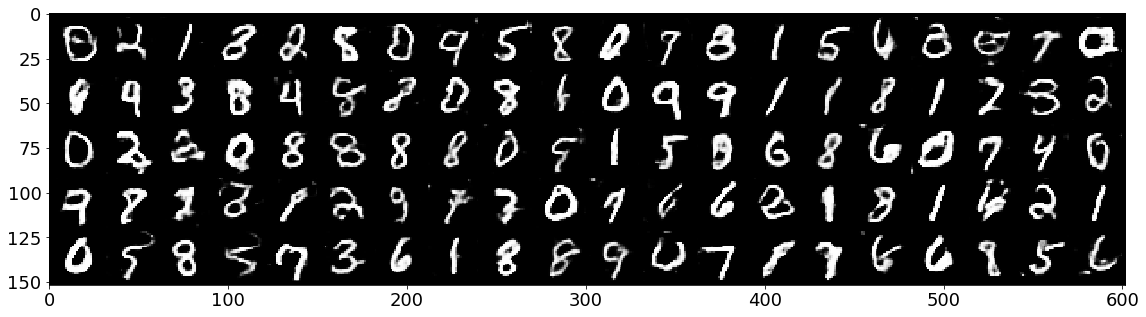

In [11]:
import kmod.plot as plot

# generate images and show
n_gen = 20*5
gen_imgs = dcgan.sample(n_gen)

plt.figure(figsize=(20, 5))
plot.show_torch_imgs(gen_imgs, nrow=20, figsize=(20, 5), normalize=True)

### Load VAE and sample

In [12]:
from kmod.mnist.vae import VAE
epochs = 20
model_folder = glo.shared_resource_folder('prob_models', 'mnist_vae', str(epochs))
model_fname = 'VAE.pkl'.format(epochs, batch_size)
model_fpath = os.path.join(model_folder, model_fname)
vae = VAE()
vae.load_state_dict(torch.load(model_fpath))

In [13]:
def vae_sample(vae, n):
    sample = torch.randn(n, 20).to(device)
    gen_imgs = vae.decode(sample)
    return gen_imgs.detach().view(n, -1, 28, 28)
    #bern = torch.distributions.Bernoulli(probs=gen_imgs)
    #return bern.sample().view(n, -1, 28, 28)

torch.Size([100, 1, 28, 28])


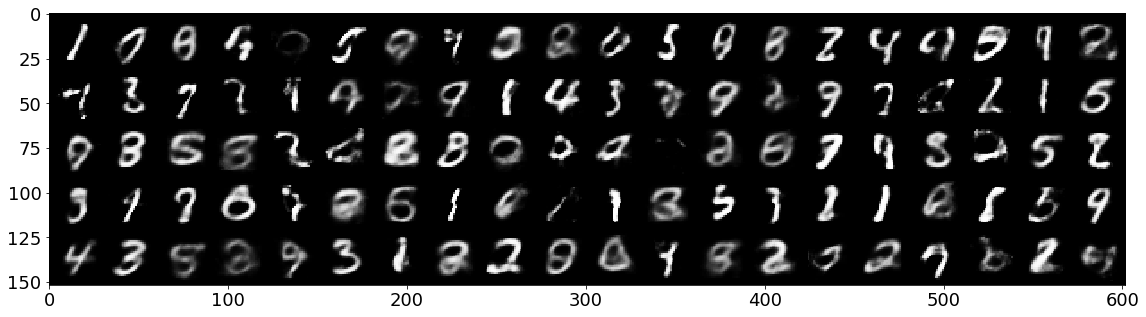

In [14]:
# generate images and show
n_gen = 20*5
gen_imgs = torch.tensor(vae_sample(vae, n_gen))
print(gen_imgs.size())

plt.figure(figsize=(20, 5))
plot.show_torch_imgs(gen_imgs, nrow=20, figsize=(20, 5))

## Load MNIST Data

In [15]:
# load MNIST data
mnist_folder = glo.data_file('mnist')
mnist_dataset = torchvision.datasets.MNIST(mnist_folder, train=False, 
                        transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

In [16]:
num_sample = 2000
classes = 10
n_sample_per_class = num_sample // classes
len_data = len(mnist_dataset)
input_Z = []
Y = torch.stack([mnist_dataset[i][1] for i in range(len_data)])
X = torch.stack([mnist_dataset[i][0] for i in range(len_data)])
for i in range(classes):
    idx = util.subsample_ind(len(Y[Y==i]), n_sample_per_class)
    input_Z.append(X[Y==i][idx])
#input_Z = [mnist_dataset[i][0] for i in range(num_sample)]
input_Z = torch.cat(input_Z).to(device)
Z = extractor(input_Z)

## Sample from generators

In [17]:
def norm(x, loc, scale):
    return (x - loc) / scale


def mnist_norm(x):
    return norm(x, 0.1307, 0.3081)

In [18]:
def trans_dcgan(x):
    y = norm(x, -1.0, 2.0)
    return mnist_norm(y)


def trans_vae(x):
    return mnist_norm(x).view(-1, 1, 28, 28)

In [19]:
X = extractor(trans_dcgan(dcgan.sample(num_sample)))
Y = extractor(mnist_norm(vae_sample(vae, num_sample)))

/nfs/nhome/live/heishirok/anaconda3/envs/clone_base/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


RuntimeError: CUDA error: out of memory

## Optimization settings

In [ ]:
J = 30

XYZ = np.vstack((X.cpu().data.numpy(), Y.cpu().data.numpy(), Z.cpu().data.numpy()))
med = util.meddistance(XYZ, subsample=1000)
gwidth0 = med
Zp0 = torch.rand([J, 100]) - 0.5
Zq0 = torch.rand([J, 20]) - 0.5 

gen_p = dcgan.module.forward
gen_q = vae.decode
trans_p = trans_dcgan
trans_q = trans_vae
featurizer = extractor

reg = 1e-4 
lam_z = 1e-6
lam_gw = 1e-6
gwidth_lb = None
gwidth_ub = None
Zp_lb= -(4.**2)
Zp_ub= 50.**2
Zq_lb= -(4.**2)
Zq_ub= 50.**2

In [ ]:
def reg_z(Zp, Zq):
    eps = 0.  # 1e-10
    log_bar_p = (torch.sum(torch.log(Zp_ub-Zp**2+eps)) 
                 if Zp_ub is not None else 0)
    # log_bar_p = (log_bar_p + torch.sum(torch.log(-Zp_lb+Zp+eps))
                 # if Zp_lb is not None else log_bar_p)
    log_bar_q = (torch.sum(torch.log(Zq_ub-Zq**2+eps)) 
                 if Zq_ub is not None else 0)
    #log_bar_q = (log_bar_q + torch.sum(torch.log(-Zq_lb+Zq+eps))
                 #if Zq_lb is not None else log_bar_q)
    return log_bar_p + log_bar_q

def reg_gw2(gwidth2):
    eps = 0.  # 1e-6
    log_bar_gwidth = (torch.log(gwidth_ub-gwidth2+eps)
                      if gwidth_ub is not None else 0)
    log_bar_gwidth = (log_bar_gwidth + (torch.log(-max(gwidth_lb, 0)+gwidth2+eps))
                      if gwidth_lb is not None else log_bar_gwidth)

    return log_bar_gwidth

## Optimization

In [ ]:
dtype = torch.float
gwidth2 = torch.tensor(gwidth0**2, requires_grad=True, device=device)
k = kernel.PTKGauss(gwidth2)
Zp = torch.tensor(Zp0, requires_grad=True, device=device,
        dtype=dtype)
Zq = torch.tensor(Zq0, requires_grad=True, device=device,
        dtype=dtype)

X = torch.tensor(X, requires_grad=False, 
                 device=device, dtype=dtype)
Y = torch.tensor(Y, requires_grad=False,
                 device=device, dtype=dtype)
Z = torch.tensor(Z, requires_grad=False,
                 device=device, dtype=dtype)

optimizer = optim.LBFGS([gwidth2, Zp, Zq], lr=1e-3, max_iter=20)
# optimizer = optim.SGD([gwidth2, Zp, Zq], lr=1e-3, momentum=0.9, nesterov=True)
# optimizer = optim.Adam([k.sigma2, Zp, Zq], lr=1e-3)
# transform = nn.Upsample((model_input_size, model_input_size), mode='bilinear')

num_steps = 2000
log_inter = 10

run = [0]
while run[0] <= num_steps:
    
    def closure():
        optimizer.zero_grad()
        im_p = gen_p(Zp)
        im_q = gen_q(Zq)
        Vp = featurizer(trans_p(im_p)) if trans_p is not None else featurizer(im_p)
        Vq = featurizer(trans_q(im_q)) if trans_q is not None else featurizer(im_q)
        power = -ume_power_criterion(X, Y, Z, Vp, Vq, k, reg)
        obj = power - lam_z*reg_z(Zp, Zq) - lam_gw*reg_gw2(k.sigma2)
        # obj = -obj
        obj.backward(retain_graph=True)
        run[0] += 1
        if run[0] % log_inter == 0:
            print('run {}'.format(run))
            print(obj, power)
        return obj
    optimizer.step(closure)

In [ ]:
gen_imgs = dcgan.forward(Zp)

In [ ]:
plt.figure(figsize=(8, 5))
plot.show_torch_imgs(gen_imgs.detach(), nrow=8, figsize=(8, 5), normalize=True)

In [ ]:
gen_imgs = vae.decode(Zq).detach().view(-1, 1, 28, 28)
plt.figure(figsize=(8, 5))
plot.show_torch_imgs(gen_imgs, nrow=8, figsize=(8, 5), normalize=True)

In [ ]:
print(Zp.max())
print(Zp.min())

In [ ]:
print(Zq.max())
print(Zq.min())

In [ ]:
print(k.sigma2, gwidth0**2)